![header image](https://storage.googleapis.com/kaggle-competitions/kaggle/7391/logos/header.png)
# Corporación Favorita Grocery Sales in Ecuador
The dataset contains sales data of groceries from a total of 46 stores in Ecuador, 18 of which are in the capital Quito. The data is collected from January 1st 2013 to late 2017.

---
## Explorative analysis

In [2]:
import pandas as pd
import numpy as np

First, load the auxilary data and quickly examine the column names and data formats.

In [3]:
items = pd.read_csv('items.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')

oil['date'] = pd.to_datetime(oil['date'])

In [10]:
with pd.read_csv('train.csv', chunksize=10**6) as reader:
    raw_train_data = reader.get_chunk(500000)
print('train.csv', raw_train_data.head(),'items.csv',items.head(), 'stores.csv', stores.head(),'oil.csv', oil.head(), sep='\n')

train.csv
   id        date  store_nbr  item_nbr  unit_sales  onpromotion
0   0  2013-01-01         25    103665         7.0          NaN
1   1  2013-01-01         25    105574         1.0          NaN
2   2  2013-01-01         25    105575         2.0          NaN
3   3  2013-01-01         25    108079         1.0          NaN
4   4  2013-01-01         25    108701         1.0          NaN
items.csv
   item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1
stores.csv
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4       

Aggregate the data to daily level without store level information.

In [15]:
# Variable for holding the resulting data frame
df=pd.DataFrame()
# Variable for holding the incomplete data of the day that was cut in half due to the chunking process.
extra=pd.DataFrame()

# Process the data in chunks to ensure memory availability
with pd.read_csv('train.csv', chunksize=10**7) as reader:
    for chunk in reader:
        chunk['date'] = pd.to_datetime(chunk['date'])
        chunk.loc[:,'onpromotion'] = chunk.loc[:,'onpromotion'].fillna(0)
        
        # Include the store information and filter by stores that are in the capital (Quito)
        chunk = chunk.merge(stores, how='left', on='store_nbr')
        chunk = chunk.loc[chunk['city']=='Quito']
        
        # Exclude the last day of the chunk and process it with the next chunk to avoid errors 
        # when computing the number of unique items, for instance.
        last_day = chunk['date'].max()
        chunk = extra.append(chunk)
        extra = chunk.loc[chunk['date']==last_day,:]
        chunk = chunk.loc[
            chunk['date']!=last_day,['date', 'unit_sales', 'onpromotion', 'item_nbr', 'store_nbr']
        ].groupby(by=['date']
        ).agg(
            unit_sales = pd.NamedAgg(column='unit_sales', aggfunc='sum'), # Number of units of items sold
            onpromotion = pd.NamedAgg(column='onpromotion', aggfunc='sum'), # Number of items on promotion
            items = pd.NamedAgg(column='item_nbr', aggfunc='nunique'), # Number of items on sale
            stores = pd.NamedAgg(column='store_nbr', aggfunc='nunique') # Number of stores open
        )
        df = df.append(chunk).sort_index()
        print(chunk.index[-1])
        
# Include oil price data once the data has been aggregated
df = df.merge(oil, how='left', on='date')
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')
df = df.set_index('date')

# Calculate additional features
df['mov_avg7']=df['unit_sales'].rolling(7).mean().fillna(method='bfill') # Average sales during the previous 7 days
df['sales_quotient']=df['mov_avg7']/df['items'] # Sales scaled by the number of items on sale
df.head()

2013-08-20 00:00:00
2014-03-05 00:00:00


/Users/elias/opt/anaconda3/envs/kandi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


2014-08-31 00:00:00
2015-01-24 00:00:00
2015-06-26 00:00:00
2015-10-21 00:00:00
2016-02-07 00:00:00
2016-05-22 00:00:00
2016-09-03 00:00:00
2016-12-14 00:00:00
2017-03-21 00:00:00
2017-06-23 00:00:00
2017-08-14 00:00:00


,unit_sales,onpromotion,items,stores,dcoilwtico,mov_avg7,sales_quotient
date,,,,,,,
2013-01-02,277399.374,0.0,1567,17,93.14,225552.034714,143.938759
2013-01-03,191233.363,0.0,1561,17,92.97,225552.034714,144.492015
2013-01-04,190918.768,0.0,1563,17,93.12,225552.034714,144.307124
2013-01-05,265459.371,0.0,1567,17,93.12,225552.034714,143.938759
2013-01-06,304714.468,0.0,1539,17,93.12,225552.034714,146.557527


,unit_sales,onpromotion,items,stores,dcoilwtico,mov_avg7,sales_quotient
unit_sales,1.000000,0.492726,0.724967,0.491130,-0.579221,0.767882,0.246892
onpromotion,0.492726,1.000000,0.778143,0.485127,-0.606011,0.682168,-0.096474
items,0.724967,0.778143,1.000000,0.679419,-0.824319,0.920984,-0.002598
stores,0.491130,0.485127,0.679419,1.000000,-0.786190,0.623279,-0.048237
dcoilwtico,-0.579221,-0.606011,-0.824319,-0.786190,1.000000,-0.745547,0.051254
mov_avg7,0.767882,0.682168,0.920984,0.623279,-0.745547,1.000000,0.375724
sales_quotient,0.246892,-0.096474,-0.002598,-0.048237,0.051254,0.375724,1.000000


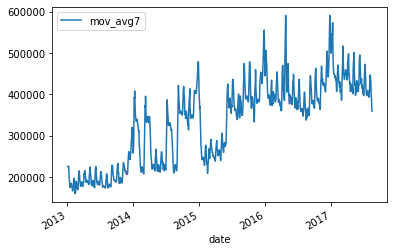

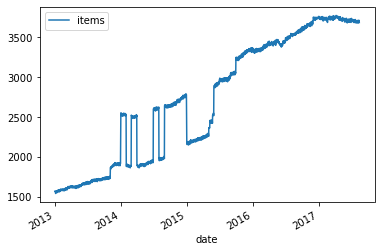

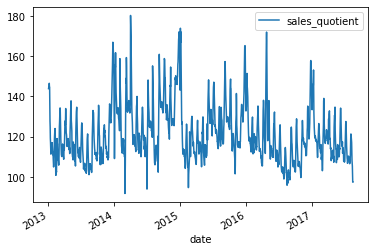

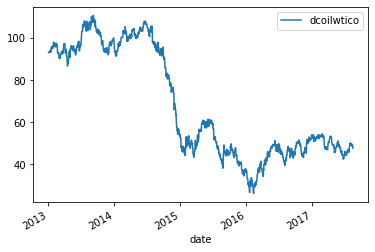

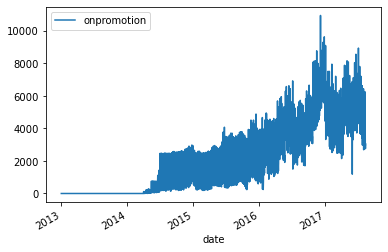

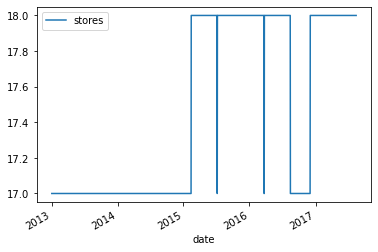

In [16]:
df.loc['2013-01-01':'2018-12-31'].plot(y=['mov_avg7'])
df.loc['2013-01-01':'2018-12-31'].plot(y=['items'])
df.loc['2013-01-01':'2018-12-31'].plot(y=['sales_quotient'])
df.loc['2013-01-01':'2018-12-31'].fillna(method='ffill').plot(y=['dcoilwtico'])
df.loc['2013-01-01':'2018-12-31'].fillna(method='ffill').plot(y=['onpromotion'])
df.loc['2013-01-01':'2018-12-31'].plot(y=['stores'])

df.corr(method='pearson')

Checking the relationship between the oil price and sales

In [13]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(df['dcoilwtico'].fillna(method='ffill').values.reshape(-1,1), df['unit_sales'])
print(reg.coef_, reg.intercept_)
reg.score(df['dcoilwtico'].fillna(method='ffill').values.reshape(-1,1), df['mov_avg7'])

[-2859.97688705] 525879.6577725728


0.5558007440083395